In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from pytorch_tabnet.tab_model import TabNetClassifier
import joblib

In [ ]:
# Load data
data = pd.read_csv("mvb_pref.csv")

## EDA

In [ ]:
data.head(10)

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,56,male,71477,bachelor,9,skiing,2477,urban,175,267,summer,0,1,1
1,69,male,88740,master,1,swimming,4777,suburban,228,190,fall,0,1,0
2,46,female,46562,master,0,skiing,1469,urban,71,280,winter,0,0,1
3,32,non-binary,99044,high school,6,hiking,1482,rural,31,255,summer,1,0,1
4,60,female,106583,high school,5,sunbathing,516,suburban,23,151,winter,1,1,0
5,25,male,110588,doctorate,3,sunbathing,2895,urban,6,47,fall,0,1,0
6,38,male,22245,bachelor,1,swimming,4994,rural,157,225,fall,0,1,0
7,56,non-binary,109411,bachelor,8,sunbathing,3656,urban,210,166,winter,1,0,0
8,36,male,22531,master,6,swimming,2408,suburban,218,263,summer,1,1,0
9,40,non-binary,90840,high school,1,swimming,4044,rural,271,15,summer,1,1,0


In [ ]:
print("Total Sample:", len(data))

Total Sample: 52444


In [ ]:
print("\nUkuran Dataset:")
print(data.shape)


Ukuran Dataset:
(52444, 14)


In [ ]:
print("\nCek Missing Value:")
print(data.isnull().sum())


Cek Missing Value:
Age                       0
Gender                    0
Income                    0
Education_Level           0
Travel_Frequency          0
Preferred_Activities      0
Vacation_Budget           0
Location                  0
Proximity_to_Mountains    0
Proximity_to_Beaches      0
Favorite_Season           0
Pets                      0
Environmental_Concerns    0
Preference                0
dtype: int64


In [ ]:
duplicate_rows = data[data.duplicated()]
num_duplicate_rows = len(duplicate_rows)
print(f"\nJumlah Data Duplikat: {num_duplicate_rows}")



Jumlah Data Duplikat: 0


In [ ]:
print("Statistik Deskriptif:")
print(data.describe())

Statistik Deskriptif:
                Age         Income  Travel_Frequency  Vacation_Budget  \
count  52444.000000   52444.000000      52444.000000     52444.000000   
mean      43.507360   70017.271280          4.489265      2741.799062   
std       14.985597   28847.560428          2.876130      1296.922423   
min       18.000000   20001.000000          0.000000       500.000000   
25%       31.000000   45048.250000          2.000000      1622.000000   
50%       43.000000   70167.000000          4.000000      2733.000000   
75%       56.000000   95108.500000          7.000000      3869.000000   
max       69.000000  119999.000000          9.000000      4999.000000   

       Proximity_to_Mountains  Proximity_to_Beaches          Pets  \
count            52444.000000          52444.000000  52444.000000   
mean               149.943502            149.888452      0.500858   
std                 86.548644             86.469248      0.500004   
min                  0.000000              0

In [ ]:
print("Distribusi Preferensi:")
print(data['Preference'].value_counts())

Distribusi Preferensi:
Preference
0    39296
1    13148
Name: count, dtype: int64


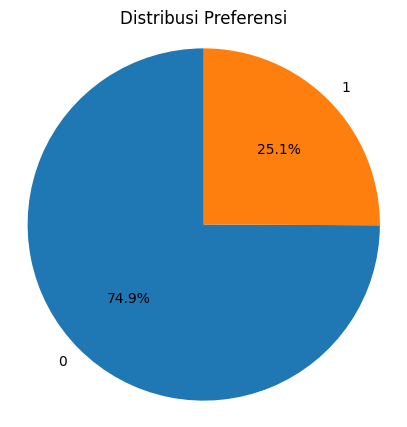

In [ ]:
plt.figure(figsize=(5, 5))
preference_counts = data['Preference'].value_counts()
plt.pie(preference_counts, labels=preference_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Preferensi')
plt.axis('equal')
plt.show()

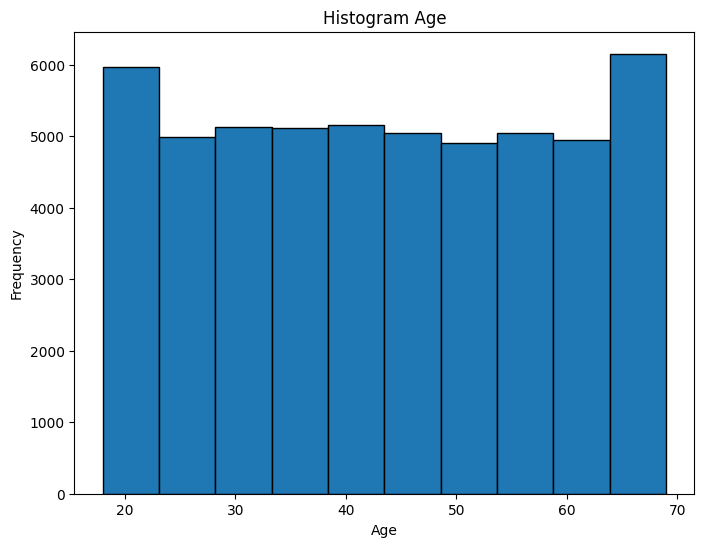

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(data['Age'], bins=10, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram Age')
plt.show()

## Pre-processing

In [ ]:

for col in data.columns:
    # Check if the column's data type is not numeric
    if not pd.api.types.is_numeric_dtype(data[col]):
        # Print the column name and its unique values
        print(f"Unique values for column '{col}':")
        print(data[col].unique())
        print("-" * 20)

Unique values for column 'Gender':
['male' 'female' 'non-binary']
--------------------
Unique values for column 'Education_Level':
['bachelor' 'master' 'high school' 'doctorate']
--------------------
Unique values for column 'Preferred_Activities':
['skiing' 'swimming' 'hiking' 'sunbathing']
--------------------
Unique values for column 'Location':
['urban' 'suburban' 'rural']
--------------------
Unique values for column 'Favorite_Season':
['summer' 'fall' 'winter' 'spring']
--------------------


In [ ]:
# Encoding Fitur Gender
gender_mapping = {'male': 0, 'female': 1, 'non-binary': 2}
data['Gender'] = data['Gender'].map(gender_mapping)

In [ ]:
# Encoding Fitur Education Level
EL_mapping = {'bachelor': 0, 'master': 1, 'high school': 2, 'doctorate': 3}
data['Education_Level'] = data['Education_Level'].map(EL_mapping)

In [ ]:
# Encoding Fitur Activities
act_mapping = {'skiing': 0, 'swimming': 1, 'hiking': 2, 'sunbathing': 3}
data['Preferred_Activities'] = data['Preferred_Activities'].map(act_mapping)

In [ ]:
# Encoding Fitur Location
loc_mapping = {'urban': 0, 'suburban': 1, 'rural': 2}
data['Location'] = data['Location'].map(loc_mapping)

In [ ]:
# Encoding Fitur Favorite Season
fav_season_mapping = {'summer': 0, 'fall': 1, 'winter': 2, 'spring': 3}
data['Favorite_Season'] = data['Favorite_Season'].map(fav_season_mapping)

In [ ]:
data = data.dropna()

In [ ]:
# Pisahkan fitur dan target
X = data.drop('Preference', axis=1)
y = data['Preference']

# StandardScaler untuk semua fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Simpan scaler untuk digunakan di web
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


In [ ]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [ ]:
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


In [ ]:
data.head()

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,0.833651,-1.221947,0.050602,-1.342879,1.568350,-1.340898,-0.204177,-1.224868,0.289510,1.354385,-1.330774,-1.001718,1.003132,1.728798
1,1.701159,-1.221947,0.649029,-0.451129,-1.213192,-0.448724,1.569269,0.000257,0.901889,0.463887,-0.436750,-1.001718,1.003132,-0.578436
2,0.166337,0.005571,-0.813084,-0.451129,-1.560885,-1.340898,-0.981409,-1.224868,-0.912137,1.504729,0.457275,-1.001718,-0.996878,1.728798
3,-0.767902,1.233088,1.006220,0.440621,0.525272,0.443450,-0.971385,1.225382,-1.374310,1.215606,-1.330774,0.998285,-0.996878,1.728798
4,1.100577,0.005571,1.267562,0.440621,0.177579,1.335624,-1.716232,0.000257,-1.466744,0.012855,0.457275,0.998285,1.003132,-0.578436


In [ ]:
# Pisahkan fitur dan target
X = data.drop('Preference', axis=1).values
y = data['Preference'].values.astype(int)


In [ ]:
# Split data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Tabnet

### Pelatihan Model

In [ ]:
# Model TabNet
model = TabNetClassifier()

# Pelatihan model
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['accuracy'],
    max_epochs=20,
    batch_size=256,
    virtual_batch_size=128
)


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.29264 | val_0_accuracy: 0.95891 |  0:00:06s
epoch 1  | loss: 0.067   | val_0_accuracy: 0.98379 |  0:00:13s
epoch 2  | loss: 0.05245 | val_0_accuracy: 0.99123 |  0:00:17s
epoch 3  | loss: 0.04038 | val_0_accuracy: 0.9918  |  0:00:23s
epoch 4  | loss: 0.04079 | val_0_accuracy: 0.98084 |  0:00:28s
epoch 5  | loss: 0.04252 | val_0_accuracy: 0.98999 |  0:00:32s
epoch 6  | loss: 0.04262 | val_0_accuracy: 0.99056 |  0:00:38s
epoch 7  | loss: 0.04026 | val_0_accuracy: 0.98522 |  0:00:42s
epoch 8  | loss: 0.04164 | val_0_accuracy: 0.98246 |  0:00:47s
epoch 9  | loss: 0.03561 | val_0_accuracy: 0.98503 |  0:00:53s
epoch 10 | loss: 0.03777 | val_0_accuracy: 0.99352 |  0:00:57s
epoch 11 | loss: 0.0379  | val_0_accuracy: 0.99571 |  0:01:01s
epoch 12 | loss: 0.03833 | val_0_accuracy: 0.98627 |  0:01:07s
epoch 13 | loss: 0.04113 | val_0_accuracy: 0.99047 |  0:01:12s
epoch 14 | loss: 0.03551 | val_0_accuracy: 0.99418 |  0:01:16s
epoch 15 | loss: 0.03475 | val_0_accuracy: 0.98722 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### Evaluasi

In [ ]:
# Prediksi pada data uji
y_pred = model.predict(X_test)

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7859
           1       0.99      0.99      0.99      2630

    accuracy                           1.00     10489
   macro avg       0.99      0.99      0.99     10489
weighted avg       1.00      1.00      1.00     10489



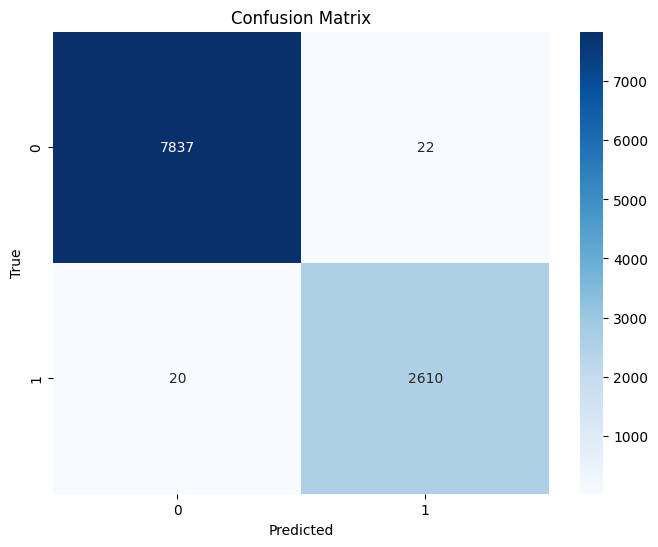

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:

model.save_model("tabnet_model.h5")

Successfully saved model at tabnet_model.h5.zip


'tabnet_model.h5.zip'

In [ ]:

model.save_model("/content/drive/MyDrive/trained_tabnet_model.h5")

Successfully saved model at /content/drive/MyDrive/trained_tabnet_model.h5.zip


'/content/drive/MyDrive/trained_tabnet_model.h5.zip'

## Feedfast Neural Network

In [ ]:
# Konversi data menjadi tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# Dataset dan DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Definisi model Feedforward Neural Network
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

In [ ]:
# Inisialisasi model
input_dim = X_train.shape[1]
hidden_dim = 64  # Jumlah neuron di hidden layer
output_dim = len(set(y))  # Jumlah kelas
model = FFNN(input_dim, hidden_dim, output_dim)

# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Pelatihan model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)

        # Menghitung loss
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # Menambahkan loss ke running loss
        running_loss += loss.item()

        # Menghitung akurasi
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    # Menghitung akurasi per epoch
    accuracy = (correct / total) * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/20, Loss: 0.4985, Accuracy: 80.30%
Epoch 2/20, Loss: 0.4774, Accuracy: 80.97%
Epoch 3/20, Loss: 0.4143, Accuracy: 91.56%
Epoch 4/20, Loss: 0.3331, Accuracy: 99.57%
Epoch 5/20, Loss: 0.3233, Accuracy: 99.63%
Epoch 6/20, Loss: 0.3205, Accuracy: 99.64%
Epoch 7/20, Loss: 0.3191, Accuracy: 99.69%
Epoch 8/20, Loss: 0.3183, Accuracy: 99.71%
Epoch 9/20, Loss: 0.3177, Accuracy: 99.74%
Epoch 10/20, Loss: 0.3173, Accuracy: 99.74%
Epoch 11/20, Loss: 0.3170, Accuracy: 99.74%
Epoch 12/20, Loss: 0.3168, Accuracy: 99.74%
Epoch 13/20, Loss: 0.3165, Accuracy: 99.76%
Epoch 14/20, Loss: 0.3163, Accuracy: 99.77%
Epoch 15/20, Loss: 0.3164, Accuracy: 99.76%
Epoch 16/20, Loss: 0.3161, Accuracy: 99.79%
Epoch 17/20, Loss: 0.3159, Accuracy: 99.80%
Epoch 18/20, Loss: 0.3158, Accuracy: 99.82%
Epoch 19/20, Loss: 0.3158, Accuracy: 99.80%
Epoch 20/20, Loss: 0.3157, Accuracy: 99.79%


### Evaluasi Model

### Pelatihan Model

In [ ]:
# Evaluasi model
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())


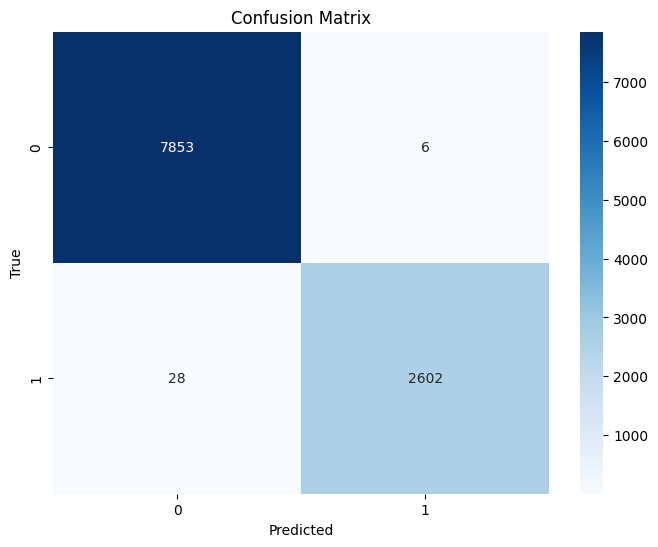

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7859
           1       1.00      0.99      0.99      2630

    accuracy                           1.00     10489
   macro avg       1.00      0.99      1.00     10489
weighted avg       1.00      1.00      1.00     10489



### Menyimpan Model

In [ ]:
# Path di Google Drive
save_path = '/content/drive/My Drive/FNN_UAP.h5'

# Simpan model ke Google Drive
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/My Drive/FNN_UAP.h5


In [ ]:
# Path di Google Drive
save_path = '/content/drive/My Drive/FNN_UAP.pth'

# Simpan model ke Google Drive
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/My Drive/FNN_UAP.pth


In [ ]:
torch.save(model.state_dict(), "FNN_UAP.pth")

## Penggunaan Model

In [ ]:
import torch
import torch.nn as nn
import shap
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

# Load model dan scaler
model = FFNN(input_dim=13, hidden_dim=64)
model.load_state_dict(torch.load("FNN_UAP.pth"))
model.eval()

scaler = joblib.load("scaler2.pkl")

# Data input dari user
user_data = [
    25,  # Age
    1,   # Gender (1 = female, 0 = male, 2 = non-binary)
    50000,  # Income
    0,   # Education_Level (0 = bachelor, 1 = master, 2 = high school, 3 = doctorate)
    2,   # Travel_Frequency
    2,   # Preferred_Activities (0 = skiing, 1 = swimming, 2 = hiking, 3 = sunbathing)
    3000,  # Vacation_Budget
    1,   # Location (0 = urban, 1 = suburban, 2 = rural)
    15,  # Proximity_to_Mountains
    50,  # Proximity_to_Beaches
    3,   # Favorite_Season (0 = summer, 1 = fall, 2 = winter, 3 = spring)
    1,   # Pets (1 = Yes, 0 = No)
    0    # Environmental_Concerns (1 = Yes, 0 = No)
]

# Preprocessing data input
user_data = np.array(user_data).reshape(1, -1)  # Bentuk array 2D
user_data_scaled = scaler.transform(user_data)

# Prediksi dengan model
output = model(torch.tensor(user_data_scaled, dtype=torch.float32))
predicted_class = torch.argmax(output, dim=1).item()  # Ambil kelas dengan probabilitas terbesar
class_probabilities = output.detach().numpy()[0]

# Tampilkan hasil prediksi
class_labels = {1: "Gunung", 0: "Pantai"}
print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Class Probabilities: {class_probabilities}")


Predicted Class: Gunung
Class Probabilities: [3.6261720e-04 9.9963737e-01]


<ipython-input-12-63913aae7499>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("FNN_UAP.pth"))
/usr/local/lib/python3.10/dist-packages/sk